<a href="https://colab.research.google.com/github/AlejandroCej/SemiAn_ProyectoFinal/blob/main/SemiAn_ProyectoFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mediapipe==0.10.13 opencv-python
import mediapipe as mp
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 13.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 4.25.8 which is incompatible.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.8 which is incompatible.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 4.25.8 which is incompatible.


Para subir el video

In [5]:
video_path = '/content/MarchaParkinson.mp4'  # Se sube video con ese nombre y formato
cap = cv2.VideoCapture(video_path)

Inicializar modelo

In [7]:
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils

Preparar video de salida

In [8]:
# Obtención de datos de video
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps    = cap.get(cv2.CAP_PROP_FPS)

#Se genera archivo vacio para video saliente
out = cv2.VideoWriter('output_video.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

inicializar frame por frame

In [9]:
left_wrist_relative = []
right_wrist_relative = []

def calculate_angle(a, b, c):
    a = np.array(a)  # First point (shoulder)
    b = np.array(b)  # Middle point (hip)
    c = np.array(c)  # Last point (knee)

    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)

    if angle > 180.0:
        angle = 360 - angle

    return angle

hip_angles = []

cap = cv2.VideoCapture(video_path)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose.process(frame_rgb)

    if results.pose_landmarks:
        mp_drawing.draw_landmarks(
            frame,
            results.pose_landmarks,
            mp_pose.POSE_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=2),
            mp_drawing.DrawingSpec(color=(0, 0, 255), thickness=2, circle_radius=2)
        )

        landmarks = results.pose_landmarks.landmark

        shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x,
                    landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
        hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x,
               landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y]
        knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].x,
                landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].y]

        angle = calculate_angle(shoulder, hip, knee)
        hip_angles.append(angle)

        lw_x = landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].x
        rw_x = landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].x
        ls_x = landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x
        rs_x = landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x

        # Relative movement (wrist relative to shoulder)
        left_wrist_relative.append(lw_x - ls_x)
        right_wrist_relative.append(rw_x - rs_x)

    # Write the frame into the file
    out.write(frame)

cap.release()
out.release()



/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Grafica de angulo de la cadera

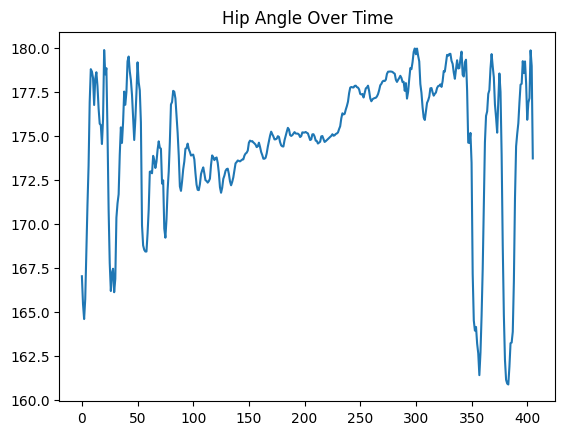

In [10]:
plt.plot(hip_angles)
plt.title('Hip Angle Over Time')
plt.show()

Graficar el balanceo de las manos al caminar

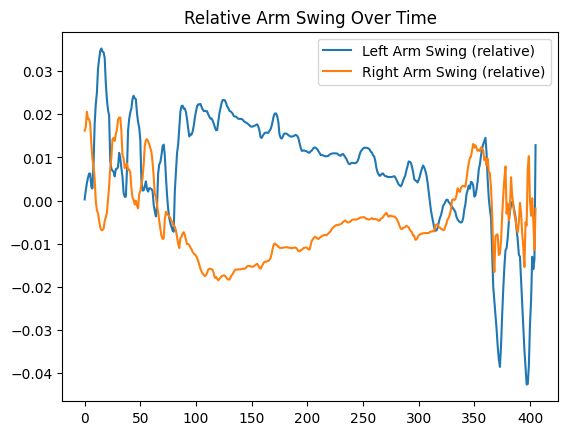

In [11]:
plt.plot(left_wrist_relative, label='Left Arm Swing (relative)')
plt.plot(right_wrist_relative, label='Right Arm Swing (relative)')
plt.legend()
plt.title('Relative Arm Swing Over Time')
plt.show()

# Preparando dataset:
Encontrar Picos y valles

In [12]:
from scipy.signal import find_peaks
import numpy as np

# Assume 'left_swing' and 'right_swing' are lists of wrist-shoulder differences over time

# Find peaks
left_peaks, _ = find_peaks(left_wrist_relative)
right_peaks, _ = find_peaks(right_wrist_relative)

# Find valleys (invert signal)
left_valleys, _ = find_peaks([-x for x in left_wrist_relative])
right_valleys, _ = find_peaks([-x for x in right_wrist_relative])

# Mean values
left_peak_mean = np.mean([left_wrist_relative[i] for i in left_peaks])
right_peak_mean = np.mean([right_wrist_relative[i] for i in right_peaks])

left_valley_mean = np.mean([left_wrist_relative[i] for i in left_valleys])
right_valley_mean = np.mean([right_wrist_relative[i] for i in right_valleys])

print("Left Peak Mean:", left_peak_mean)
print("Right Peak Mean:", right_peak_mean)
print("Left Valley Mean:", left_valley_mean)
print("Right Valley Mean:", right_valley_mean)

Left Peak Mean: 0.012314316028585801
Right Peak Mean: -0.0016767832416075248
Left Valley Mean: 0.005375101338498867
Right Valley Mean: -0.005758708308416384
